<a href="https://colab.research.google.com/github/miya498/image_delete_fence/blob/master/delete_fence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##柵自動削除モデル
・画像内正面にある柵を自動で検出して削除するモデル

・主にMiDas(深度推定モデル)とLaMa(画像修復モデル)を使用した

【実行】1枚の画像(ex.input_base.jpg)を下のコードからアップロードして、順に実行すれば柵が除去された画像を出力します

<img src="https://github.com/miya498/image_delete_fence/blob/master/image/inpaint_img.jpg" alt="alt" width="50%"/>



# 深度推定

## MiDaS深度推定
### This notebook is optionally accelerated with a GPU runtime.
### If you would like to use this acceleration, please select the menu option "Runtime" -> "Change runtime type", select "Hardware Accelerator" -> "GPU" and click "SAVE"

----------------------------------------------------------------------

# MiDaS

*Author: Intel ISL*

**MiDaS models for computing relative depth from a single image.**

<img src="https://pytorch.org/assets/images/midas_samples.png" alt="alt" width="50%"/>


### Model Description

[MiDaS](https://arxiv.org/abs/1907.01341) computes relative inverse depth from a single image. The repository provides multiple models that cover different use cases ranging from a small, high-speed model to a very large model that provide the highest accuracy. The models have been trained on 10 distinct datasets using
multi-objective optimization to ensure high quality on a wide range of inputs.

### Dependencies

MiDaS depends on [timm](https://github.com/rwightman/pytorch-image-models). Install with

## データの読み込み

In [1]:
import os
import base64
from base64 import b64decode
import cv2
import torch
import urllib.request
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import glob
from shutil import copyfile
import shutil
import copy

In [2]:
#Midas用
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 8.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [3]:
from google.colab import files
files = files.upload()
fname = list(files.keys())[0]

Saving input_base.jpg to input_base.jpg


In [4]:
# 深度推定モデルlの読み込み
model_type = "DPT_Large"
midas = torch.hub.load("intel-isl/MiDaS", model_type)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

/usr/local/lib/python3.10/dist-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/isl-org/MiDaS/releases/download/v3/dpt_large_384.pt" to /root/.cache/torch/hub/checkpoints/dpt_large_384.pt
100%|██████████| 1.28G/1.28G [00:14<00:00, 93.9MB/s]


DPTDepthModel(
  (pretrained): Module(
    (model): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_featur

In [5]:
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


## 深度推定の実行

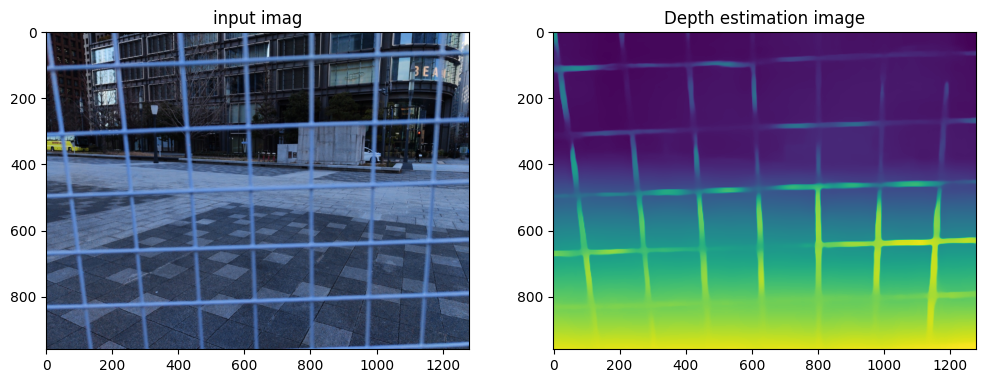

In [6]:
img = cv2.imread(fname)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.GaussianBlur(img, (311, 311), 4)

input_batch = transform(img).to(device)

with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

output = prediction.cpu().numpy()

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].set_title("input imag")
axs[1].set_title("Depth estimation imag")
axs[0].imshow(img, cmap="gray", vmin=0, vmax=255)
axs[1].imshow(output, cmap="gray", vmin=-0.001, vmax=0.001)

plt.title("Depth estimation image")
plt.imshow(output)
plt.show()

# 深度推定後のエッジ画像を元にマスク画像の作成

In [7]:
class Mask:
    def __init__(self, edge_img):
        self.edge_img = edge_img


    def judge_line(self, line_img, ratio=0.71):
        judge_img = self.edge_img * line_img
        if np.sum(judge_img) / np.sum(line_img) > ratio:
            return True
        else:
            return False


    def get_mask(self):
        mask_img = self.get_vertical_mask() + self.get_holizontal_mask()
        mask_img[mask_img > 1] = 1
        return mask_img


    def get_vertical_mask(self):
        cols, rows = self.edge_img.shape
        mask_pre_img = np.zeros([cols, rows*3], dtype="uint8")
        for _ in range(2):
            for row_low in range(0, rows, 5):
                for shift in range(0, rows*2-row_low, 5):
                    line_pre_img = np.zeros([cols, rows*3], dtype="uint8")
                    cv2.line(line_pre_img, (row_low+shift, 0), (rows+shift, cols-1), 1, 1)
                    line_img = line_pre_img[:, rows:rows*2]
                    if self.judge_line(line_img, 0.71):
                        cv2.line(mask_pre_img, (row_low+shift, 0), (rows+shift, cols-1), 1, 10)
            self.edge_img = cv2.flip(self.edge_img, 1)
            mask_pre_img = cv2.flip(mask_pre_img, 1)
        mask_img = mask_pre_img[:, rows:rows*2]
        return mask_img


    def get_holizontal_mask(self):
        self.edge_img = cv2.rotate(self.edge_img, cv2.ROTATE_90_CLOCKWISE)
        mask_img = self.get_vertical_mask()
        self.edge_img = cv2.rotate(self.edge_img, cv2.ROTATE_90_COUNTERCLOCKWISE)
        mask_img = cv2.rotate(mask_img, cv2.ROTATE_90_COUNTERCLOCKWISE)
        return mask_img

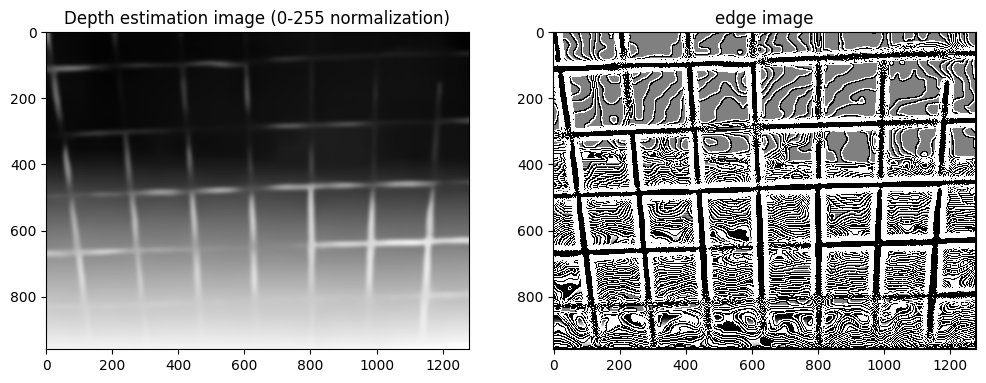

In [8]:
# 深度推定後の画像のエッジ画像
gray = cv2.normalize(output, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)  # 0-255に規格化
blur_sigma = 5
gray = cv2.GaussianBlur(gray, (311, 311), blur_sigma)  # ガウスで平滑化（もっと小さくても良い平滑かのマスクサイズは(311, 311）にしているが特に意味はない。σの大きさはどこが適切か。

kernel = np.array([[1, 1, 1], [1, -8, 1], [1, 1, 1]])
edge = signal.convolve(gray, kernel, mode="same")

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].set_title("Depth estimation image (0-255 normalization)")
axs[1].set_title("edge image")
axs[0].imshow(gray, cmap="gray", vmin=0, vmax=255)
axs[1].imshow(edge, cmap="gray", vmin=-0.001, vmax=0.001)
plt.show()

保存したエッジ画像


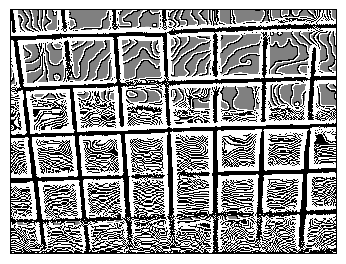

In [9]:
# エッジ画像を低画質で保存（計算高速化のため）

# 302で割ると丁度縦横半分の画質になる
fig_row = edge.shape[1] / 302
fig_col = edge.shape[0] / 302

fig, ax = plt.subplots(1, 1, dpi=100, figsize=(fig_row, fig_col))

ax.imshow(edge, cmap="gray", vmin=-0.001, vmax=0.001)
ax.axis("off")
plt.savefig("edge.jpg", bbox_inches='tight', pad_inches=0)
edge_img = cv2.imread("tes.jpg", cv2.IMREAD_GRAYSCALE)
print("保存したエッジ画像")
plt.show()

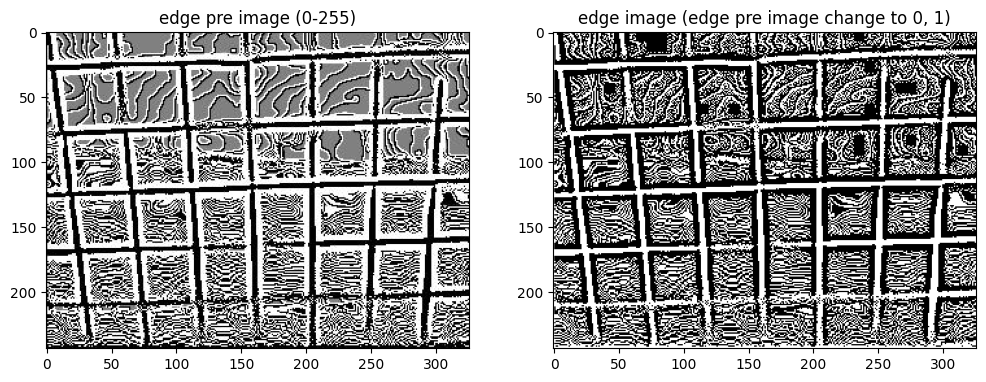

In [10]:
# エッジ画像の読み込み
fname_edge = "edge.jpg"
edge_pre_img = cv2.imread(fname_edge, cv2.IMREAD_GRAYSCALE)
cols, rows = edge_pre_img.shape

edge_img = np.zeros_like(edge_pre_img, dtype="uint8")
edge_img[edge_pre_img < 127] = 1  # 画像の2値化

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].set_title("edge pre image (0-255)")
axs[1].set_title("edge image (edge pre image change to 0, 1)")
axs[0].imshow(edge_pre_img, cmap="gray", vmin=0, vmax=255)
axs[1].imshow(edge_img, cmap="gray", vmin=0, vmax=1)

plt.show()

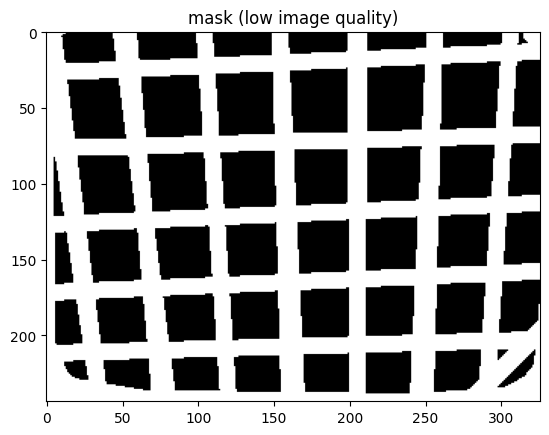

In [11]:
# マスクの作成（低画質）
mask = Mask(edge_img)
mask_img = mask.get_mask()

plt.title("mask (low image quality)")
plt.imshow(mask_img, cmap="gray", vmin=0, vmax=1)
plt.show()

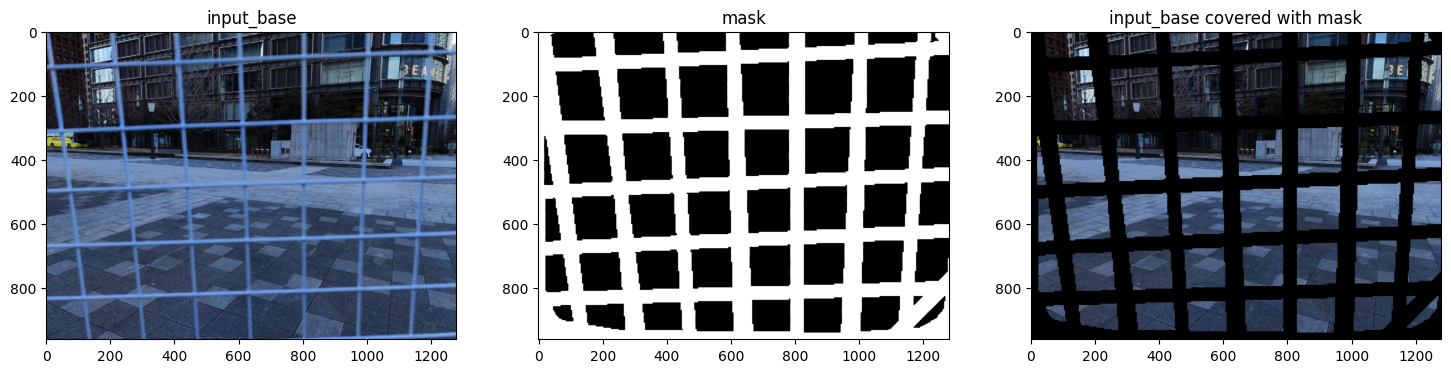

In [12]:
# input_base画像
img = cv2.imread(fname)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# mask画像をinput_base画像に合わせて拡大
mask_img = cv2.resize(mask_img, (img.shape[1], img.shape[0]))
mask_img[mask_img == 1] = 255  # 白(255)に置換

# input_baseにmask画像を被せる（柵の推定するときにこの画像は不要）
img_cover_mask = copy.deepcopy(img)
img_cover_mask[mask_img == 255] = [0, 0, 0]

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].set_title("input_base")
axs[1].set_title("mask")
axs[2].set_title("input_base covered with mask")
axs[0].imshow(img)
axs[1].imshow(mask_img, cmap="gray", vmin=0, vmax=255)
axs[2].imshow(img_cover_mask)

# マスク画像の保存
cv2.imwrite(fname.replace(".jpg", "_mask_img.png"), mask_img)

plt.show()

# LaMa-inpaintingによるマスク部分の画像修復

# 🦙 LaMa: Resolution-robust Large Mask Inpainting with Fourier Convolutions

by Roman Suvorov, Elizaveta Logacheva, Anton Mashikhin,
Anastasia Remizova, Arsenii Ashukha, Aleksei Silvestrov, Naejin Kong, Harshith Goka, Kiwoong Park, Victor Lempitsky.

<p align="center" "font-size:30px;">
  🔥🔥🔥
  <br>
  <b>
LaMa generalizes surprisingly well to much higher resolutions (~2k❗️) than it saw during training (256x256), and achieves the excellent performance even in challenging scenarios, e.g. completion of periodic structures.</b>
</p>

[[Project page](https://advimman.github.io/lama-project/)] [[arXiv](https://arxiv.org/abs/2109.07161)] [[Supplementary](https://ashukha.com/projects/lama_21/lama_supmat_2021.pdf)] [[BibTeX](https://senya-ashukha.github.io/projects/lama_21/paper.txt)] [[Casual GAN Papers Summary](https://www.casualganpapers.com/large-masks-fourier-convolutions-inpainting/LaMa-explained.html)]

<p align="center">
  <a href="https://colab.research.google.com/github/advimman/lama/blob/master//colab/LaMa_inpainting.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg"/>
  </a>
      <br>
   Try out in Google Colab
</p>

<p align="center">
  <img src="https://raw.githubusercontent.com/senya-ashukha/senya-ashukha.github.io/master/projects/lama_21/ezgif-4-0db51df695a8.gif" />
</p>



In [16]:
from PIL import Image

In [18]:
def pil2cv(image):
    ''' PIL型 -> OpenCV型 '''
    new_image = np.array(image, dtype=np.uint8)
    if new_image.ndim == 2:  # モノクロ
        pass
    elif new_image.shape[2] == 3:  # カラー
        new_image = new_image[:, :, ::-1]
    elif new_image.shape[2] == 4:  # 透過
        new_image = new_image[:, :, [2, 1, 0, 3]]
    return new_image


・cv2.imread()に引数としてそれぞれのパスを指定してください。

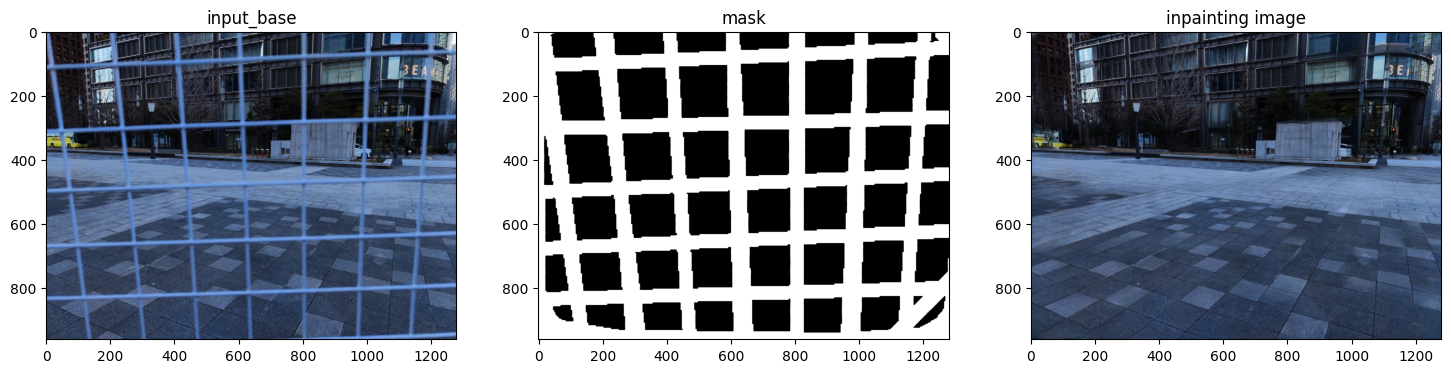

In [24]:
!pip install simple-lama-inpainting
from simple_lama_inpainting import SimpleLama

simple_lama= SimpleLama()
# input_base画像(imread)
#img = cv2.imread(fname)
img = cv2.imread("/content/input_base.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# mask画像
#mask_img = cv2.imread(fname.replace(".jpg", "_mask_img.png"))
mask_img = cv2.imread("/content/input_base_mask_img.png")

# LaMaの画像修復の結果
image = Image.open("/content/input_base.jpg")
mask = Image.open("/content/input_base_mask_img.png").convert("L")
inpainting_img = simple_lama(img,mask)
inpainting_img = pil2cv(inpainting_img)
inpainting_img = cv2.cvtColor(inpainting_img, cv2.COLOR_BGR2RGB)
cv2.imwrite("inpaint_img.jpg",inpainting_img)

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].set_title("input_base")
axs[1].set_title("mask")
axs[2].set_title("inpainting image")
axs[0].imshow(img)
axs[1].imshow(mask_img, cmap="gray", vmin=0, vmax=255)
axs[2].imshow(inpainting_img)

plt.show()